<a href="https://colab.research.google.com/github/alessandrobruni/tensorflow_text/blob/main/C3_W4_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C3/W4/ungraded_labs/C3_W4_Lab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Generating Text with Neural Networks

For this week, you will look at techniques to prepare data and build models for text generation. You will train a neural network with lyrics from an Irish song then let it make a new song for you. Though this might sound like a more complex application, you'll soon see that the process is very similar to the ones you've been using in the previous weeks. Only minor modifications are needed. Let's see what these are in the next sections.

## Imports

First, you will import the required libraries. You've used all of these already in the previous labs.

In [1]:
import tensorflow as tf
import numpy as np 
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Building the Word Vocabulary

The dataset is the lyrics of [*Lanigan's Ball*](https://en.wikipedia.org/wiki/Lanigan%27s_Ball), a traditional Irish song. You will split it per line then use the `Tokenizer` class to build the word index dictionary.

In [47]:
# Define the lyrics of the song
data="in primis il matrimonio dell'8 settembre.\n È SOLO A TE che serve avere Michele appresso.\n Un bimbo di quasi 5 anni,\n cosa vuoi che gliene importi che si sposi una TUA amica (neanche una parente) terrona,\n che non si sa neppure quante volte avrà visto in vita sua? Che poi neanche si sa chi sia.\n Mistero.\n Eh si, la Sibilla non dice mai tutto.\n Michele penso stia anche più che volentieri col suo papà Diego, quel week end.\n In seconda battuta, potresti trovare una scusa diversa dal mare calabro,\n che tanto giova a Michele,\n per coprire la tua dipendenza psicologica ed emotiva\n dalla tribù terrona nella quale sei nata,\n dalla quale non sei ancora riuscita a tagliare il cordone ombelicale,\n e alla soddisfazione degli interessi della quale hai posposto le esigenze di tuo marito\n e continui a posporre anche le esigenze di tuo figlio.\n Esimia Professoressa \n che insegna forse anche geografia,\n sai che Padova è ad un'ora di auto dal mare?\n Michele lo puoi anche portare al mare in giornata,\n stando a Padova di pernotto.\n E magari si diverte anche di più \n che andare sempre in quei 50 metri di spiaggia a Riace,\n dove temo condannerai Michele ad andare\n fino a che avrà 18 anni.\n Poi credo ti manderà finalmente a farti benedire.\n"
# Split the long string per line and put in a list
corpus = data.lower()\
.replace("." ,"" )\
.replace(";","")\
.replace(",","")\
.replace("(","")\
.replace(")","")\
.replace("?","")\
.replace("!","")\
.split("\n")

# Preview the result
print(corpus)

["in primis il matrimonio dell'8 settembre", ' è solo a te che serve avere michele appresso', ' un bimbo di quasi 5 anni', ' cosa vuoi che gliene importi che si sposi una tua amica neanche una parente terrona', ' che non si sa neppure quante volte avrà visto in vita sua che poi neanche si sa chi sia', ' mistero', ' eh si la sibilla non dice mai tutto', ' michele penso stia anche più che volentieri col suo papà diego quel week end', ' in seconda battuta potresti trovare una scusa diversa dal mare calabro', ' che tanto giova a michele', ' per coprire la tua dipendenza psicologica ed emotiva', ' dalla tribù terrona nella quale sei nata', ' dalla quale non sei ancora riuscita a tagliare il cordone ombelicale', ' e alla soddisfazione degli interessi della quale hai posposto le esigenze di tuo marito', ' e continui a posporre anche le esigenze di tuo figlio', ' esimia professoressa ', ' che insegna forse anche geografia', " sai che padova è ad un'ora di auto dal mare", ' michele lo puoi anch

In [40]:
# Initialize the Tokenizer class
tokenizer = Tokenizer()

# Generate the word index dictionary
tokenizer.fit_on_texts(corpus)

# Define the total words. You add 1 for the index `0` which is just the padding token.
total_words = len(tokenizer.word_index) + 1

print(f'word index dictionary: {tokenizer.word_index}')
print(f'total words: {total_words}')


word index dictionary: {'che': 1, 'a': 2, 'di': 3, 'in': 4, 'michele': 5, 'si': 6, 'anche': 7, 'una': 8, 'non': 9, 'mare': 10, 'quale': 11, 'e': 12, 'il': 13, 'è': 14, 'anni': 15, 'tua': 16, 'neanche': 17, 'terrona': 18, 'sa': 19, 'avrà': 20, 'poi': 21, 'la': 22, 'più': 23, 'dal': 24, 'dalla': 25, 'sei': 26, 'le': 27, 'esigenze': 28, 'tuo': 29, 'padova': 30, 'ad': 31, 'andare': 32, 'primis': 33, 'matrimonio': 34, "dell'8": 35, 'settembre': 36, 'solo': 37, 'te': 38, 'serve': 39, 'avere': 40, 'appresso': 41, 'un': 42, 'bimbo': 43, 'quasi': 44, '5': 45, 'cosa': 46, 'vuoi': 47, 'gliene': 48, 'importi': 49, 'sposi': 50, 'amica': 51, 'parente': 52, 'neppure': 53, 'quante': 54, 'volte': 55, 'visto': 56, 'vita': 57, 'sua': 58, 'chi': 59, 'sia': 60, 'mistero': 61, 'eh': 62, 'sibilla': 63, 'dice': 64, 'mai': 65, 'tutto': 66, 'penso': 67, 'stia': 68, 'volentieri': 69, 'col': 70, 'suo': 71, 'papà': 72, 'diego': 73, 'quel': 74, 'week': 75, 'end': 76, 'seconda': 77, 'battuta': 78, 'potresti': 79, 't

## Preprocessing the Dataset

Next, you will be generating the training sequences and their labels. As discussed in the lectures, you will take each line of the song and generate inputs and labels from it. For example, if you only have one sentence: "I am using Tensorflow", you want the model to learn the next word given any subphrase of this sentence:

```
INPUT              LABEL
-----------------------------
I             ---> am
I am          ---> using
I am using    ---> Tensorflow
```

The next cell shows how to implement this concept in code. The result would be inputs as padded sequences, and labels as one-hot encoded arrays.

In [66]:
# Initialize the sequences list
input_sequences = []

# Loop over every line
for line in corpus:

	# Tokenize the current line
	token_list = tokenizer.texts_to_sequences([line])[0]
	print(line)
	print(token_list)
  
	print(tokenizer.texts_to_sequences([line]))

	# Loop over the line several times to generate the subphrases
	for i in range(1, len(token_list)):
		
		# Generate the subphrase
		n_gram_sequence = token_list[:i+1]

		# Append the subphrase to the sequences list
		input_sequences.append(n_gram_sequence)

# Get the length of the longest line
max_sequence_len = max([len(x) for x in input_sequences])
print(f"MAX sequence lenght   : {max_sequence_len}")

# Pad all sequences
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create inputs and label by splitting the last token in the subphrases
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
print(f"total lables resulting from the padding  : \n{labels}")
print(f"total lables resulting from the padding  : \n{len(labels)}")
# Convert the label into one-hot arrays
print(f"total word : {total_words}")
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

in primis il matrimonio dell'8 settembre
[4, 33, 13, 34, 35, 36]
[[4, 33, 13, 34, 35, 36]]
 è solo a te che serve avere michele appresso
[14, 37, 2, 38, 1, 39, 40, 5, 41]
[[14, 37, 2, 38, 1, 39, 40, 5, 41]]
 un bimbo di quasi 5 anni
[42, 43, 3, 44, 45, 15]
[[42, 43, 3, 44, 45, 15]]
 cosa vuoi che gliene importi che si sposi una tua amica neanche una parente terrona
[46, 47, 1, 48, 49, 1, 6, 50, 8, 16, 51, 17, 8, 52, 18]
[[46, 47, 1, 48, 49, 1, 6, 50, 8, 16, 51, 17, 8, 52, 18]]
 che non si sa neppure quante volte avrà visto in vita sua che poi neanche si sa chi sia
[1, 9, 6, 19, 53, 54, 55, 20, 56, 4, 57, 58, 1, 21, 17, 6, 19, 59, 60]
[[1, 9, 6, 19, 53, 54, 55, 20, 56, 4, 57, 58, 1, 21, 17, 6, 19, 59, 60]]
 mistero
[61]
[[61]]
 eh si la sibilla non dice mai tutto
[62, 6, 22, 63, 9, 64, 65, 66]
[[62, 6, 22, 63, 9, 64, 65, 66]]
 michele penso stia anche più che volentieri col suo papà diego quel week end
[5, 67, 68, 7, 23, 1, 69, 70, 71, 72, 73, 74, 75, 76]
[[5, 67, 68, 7, 23, 1, 69, 70, 

Let's see the result for the first line of the song. The particular line and the expected token sequence is shown in the cell below:

In [67]:
# Get sample sentence
sentence = corpus[0].split()
print(f'sample sentence: {sentence}')

# Initialize token list
token_list = []

# Look up the indices of each word and append to the list
for word in sentence: 
  print(word)
  print(tokenizer.word_index[word])
  token_list.append(tokenizer.word_index[word])

# Print the token list
print(token_list)

sample sentence: ['in', 'primis', 'il', 'matrimonio', "dell'8", 'settembre']
in
4
primis
33
il
13
matrimonio
34
dell'8
35
settembre
36
[4, 33, 13, 34, 35, 36]


Since there are 8 tokens here, you can expect to find this particular line in the first 7 elements of the `xs` that you generated earlier. If we get the longest subphrase generated, that should be found in `xs[6]`. See the padded token sequence below:

In [68]:
# Pick element
elem_number = 6

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')


token list: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14 37]
decoded to text: ['è solo']
token list: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14]
decoded to text: ['è']


If you print out the label, it should show `70` because that is the next word in the phrase (i.e. `lanigan`). See the one-hot encoded form below. You can use the [`np.argmax()`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) method to get the index of the 'hot' label.

In [69]:
# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')
print(len(ys))

one-hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
index of label: 37
188


If you pick the element before that, you will see the same subphrase as above minus one word:

In [70]:
# Pick element
elem_number = 5

# Print token list and phrase
print(f'token list: {xs[elem_number]}')
print(f'decoded to text: {tokenizer.sequences_to_texts([xs[elem_number]])}')

# Print label
print(f'one-hot label: {ys[elem_number]}')
print(f'index of label: {np.argmax(ys[elem_number])}')

token list: [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 14]
decoded to text: ['è']
one-hot label: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]
index of label: 37


## Build the Model

Next, you will build the model with basically the same layers as before. The main difference is you will remove the sigmoid output and use a softmax activated `Dense` layer instead. This output layer will have one neuron for each word in the vocabulary. So given an input token list, the output array of the final layer will have the probabilities for each word.

In [71]:
# Build the model
model = Sequential([
          Embedding(total_words, 64, input_length=max_sequence_len-1),
          Bidirectional(LSTM(20)),
          Dense(total_words, activation='softmax')
])

# Use categorical crossentropy because this is a multi-class problem
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 64)            9280      
                                                                 
 bidirectional (Bidirectiona  (None, 40)               13600     
 l)                                                              
                                                                 
 dense (Dense)               (None, 145)               5945      
                                                                 
Total params: 28,825
Trainable params: 28,825
Non-trainable params: 0
_________________________________________________________________


## Train the model

You can now train the model. We have a relatively small vocabulary so it will only take a couple of minutes to complete 500 epochs.

In [72]:
# Train the model
history = model.fit(xs, ys, epochs=500)

Epoch 1/500
6/6 [==============================] - 5s 25ms/step - loss: 4.9773 - accuracy: 0.0053
Epoch 2/500
6/6 [==============================] - 0s 19ms/step - loss: 4.9686 - accuracy: 0.0426
Epoch 3/500
6/6 [==============================] - 0s 17ms/step - loss: 4.9609 - accuracy: 0.0426
Epoch 4/500
6/6 [==============================] - 0s 16ms/step - loss: 4.9517 - accuracy: 0.0426
Epoch 5/500
6/6 [==============================] - 0s 16ms/step - loss: 4.9388 - accuracy: 0.0426
Epoch 6/500
6/6 [==============================] - 0s 59ms/step - loss: 4.9190 - accuracy: 0.0426
Epoch 7/500
6/6 [==============================] - 0s 22ms/step - loss: 4.8900 - accuracy: 0.0426
Epoch 8/500
6/6 [==============================] - 0s 16ms/step - loss: 4.8459 - accuracy: 0.0426
Epoch 9/500
6/6 [==============================] - 0s 16ms/step - loss: 4.7913 - accuracy: 0.0426
Epoch 10/500
6/6 [==============================] - 0s 16ms/step - loss: 4.7408 - accuracy: 0.0426
Epoch 11/500
6/6 [=

You can visualize the results with the utility below. With the default settings, you should see around 95% accuracy after 500 epochs.

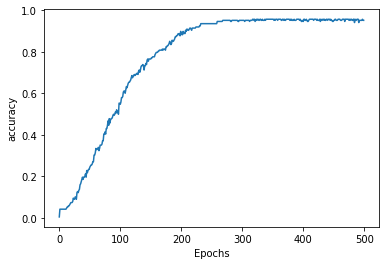

In [73]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')

## Generating Text

With the model trained, you can now use it to make its own song! The process would look like:

1. Feed a seed text to initiate the process.
2. Model predicts the index of the most probable next word.
3. Look up the index in the reverse word index dictionary
4. Append the next word to the seed text.
5. Feed the result to the model again.

Steps 2 to 5 will repeat until the desired length of the song is reached. See how it is implemented in the code below:

In [74]:
# Define seed text
seed_text = "Tu lo porti la mare"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
	token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
	probabilities = model.predict(token_list)

	# Get the index with the highest probability
	predicted = np.argmax(probabilities, axis=-1)[0]

	# Ignore if index is 0 because that is just the padding.
	if predicted != 0:
		
		# Look up the word associated with the index. 
		output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
		seed_text += " " + output_word

# Print the result	
print(seed_text)

1/1 [==============================] - 0s 31ms/step
Tu lo porti la mare non si quante volte avrà visto in vita sua che poi neanche si sa chi sia sia sia sia sia chi sia sia sia sia sia chi sia sia sia sia sia sia sia sia sia sia sia sia sia sia sia sia sia sia end parente terrona nella quale nata nata nata nata nata nata nata nata nata nata nata nata nata nata nata ad chi sia chi sia sia sia sia sia sia sia sia end end una ombelicale michele end end volentieri di esigenze end end marito tuo marito marito figlio le esigenze di tuo end marito


In the output above, you might notice frequent repetition of words the longer the sentence gets. There are ways to get around it and the next cell shows one. Basically, instead of getting the index with max probability, you will get the top three indices and choose one at random. See if the output text makes more sense with this approach. This is not the most time efficient solution because it is always sorting the entire array even if you only need the top three. Feel free to improve it and of course, you can also develop your own method of picking the next word.

In [76]:
# Define seed text
seed_text = "Tu lo porti la mare"

# Define total words to predict
next_words = 100

# Loop until desired length is reached
for _ in range(next_words):

	# Convert the seed text to a token sequence
  token_list = tokenizer.texts_to_sequences([seed_text])[0]

	# Pad the sequence
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	
	# Feed to the model and get the probabilities for each index
  probabilities = model.predict(token_list)

  # Pick a random number from [1,2,3]
  choice = np.random.choice([1,2,3])
	
  # Sort the probabilities in ascending order 
  # and get the random choice from the end of the array
  predicted = np.argsort(probabilities)[0][-choice]

	# Ignore if index is 0 because that is just the padding.
  if predicted != 0:
		
		# Look up the word associated with the index. 
	  output_word = tokenizer.index_word[predicted]

		# Combine with the seed text
	  seed_text += " " + output_word

# Print the result	
print(seed_text)

1/1 [==============================] - 0s 24ms/step
Tu lo porti la mare che sa volte visto visto avrà sa sua in poi poi volte poi avrà visto è giornata che poi sa diego sia end quel sia week mare sia sia sia end chi end end end end neanche dal mare mai sia sia poi sua a chi sia sia sia trovare sia chi end chi chi end end end sia sia chi chi sia end chi sia sia chi sia mare end chi sia end chi sia sia sia end mare sia sia end sia chi mare sia sia chi sposi mare mare mare sua neanche che neanche sa week end


## Wrap Up

In this lab, you got a first look at preparing data and building a model for text generation. The corpus is fairly small in this particular exercise and in the next lessons, you will be building one from a larger body of text. See you there!